In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import stats
import scipy.stats as ss
import os
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
import catboost as cat
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
from category_encoders import MEstimateEncoder
from sklearn.model_selection import train_test_split
import optuna
from itertools import combinations

In [2]:
path = '..//'

In [3]:
train = pd.read_csv(os.path.join(path,'train.csv'))
test = pd.read_csv(os.path.join(path,'test.csv'))

In [29]:
test.head()

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,TYPE_OF_VEHICLE
0,352928,2,1,1,1,3,0.814707,1.0,0,0.0,1.0,10238,10000,0,0,0,0
1,38579,1,0,2,0,2,0.344051,1.0,1,0.0,0.0,34073,13000,0,0,0,2
2,504022,2,1,1,1,2,0.620691,0.0,0,1.0,0.0,10238,12000,0,0,0,1
3,202404,1,1,2,0,2,0.689658,1.0,0,1.0,1.0,10238,16000,1,0,0,1
4,527913,3,1,1,1,0,0.755666,0.0,0,0.0,1.0,92101,14000,2,0,0,0


d:\python3.9\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='OUTCOME', ylabel='count'>

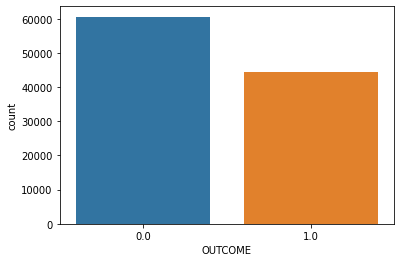

In [5]:
sns.countplot(train['OUTCOME'])

<AxesSubplot:xlabel='DRIVING_EXPERIENCE', ylabel='count'>

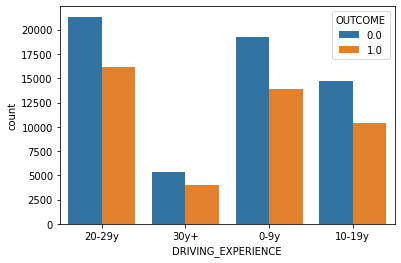

In [108]:
sns.countplot(x="DRIVING_EXPERIENCE", hue="OUTCOME", data=train)

<AxesSubplot:xlabel='ANNUAL_MILEAGE', ylabel='count'>

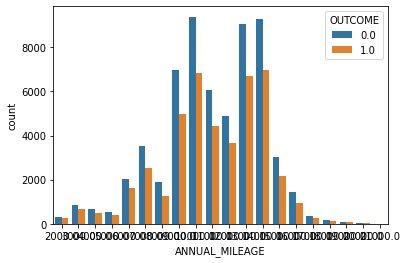

In [166]:
sns.countplot(x="ANNUAL_MILEAGE", hue="OUTCOME", data=train)

In [113]:
train['DRIVING_EXPERIENCE'].unique()

array(['20-29y', '30y+', '0-9y', '10-19y'], dtype=object)

In [24]:
len(test.columns)

33

In [14]:
train.columns

Index(['ID', 'AGE', 'GENDER', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME',
       'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'VEHICLE_YEAR', 'MARRIED',
       'CHILDREN', 'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS',
       'DUIS', 'PAST_ACCIDENTS', 'OUTCOME', 'TYPE_OF_VEHICLE'],
      dtype='object')

In [5]:
cat_cols = [ 'GENDER', 'EDUCATION', 'INCOME',
            'VEHICLE_YEAR','TYPE_OF_VEHICLE']

In [6]:
def cramers_v(x, y):
    
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [28]:
for i in train.columns:
    
    print(f'{i} correlation {cramers_v(train[i], train["OUTCOME"])}')

ID correlation 0.0
AGE correlation 0.0
GENDER correlation 0.011258020957786547
DRIVING_EXPERIENCE correlation 0.0137054683829392
EDUCATION correlation 0.0
INCOME correlation 0.0
CREDIT_SCORE correlation 0.0
VEHICLE_OWNERSHIP correlation 0.0
VEHICLE_YEAR correlation 0.0
MARRIED correlation 0.005154960958728126
CHILDREN correlation 0.0
POSTAL_CODE correlation 0.0
ANNUAL_MILEAGE correlation 0.012915204296091592
SPEEDING_VIOLATIONS correlation 0.009360608827442572
DUIS correlation 0.0
PAST_ACCIDENTS correlation 0.0
OUTCOME correlation 0.9999804851393885
TYPE_OF_VEHICLE correlation 0.009083320850949017


In [36]:
def feature_engineering(df, df1):
    
    
    for i in cat_cols:
        
        le = LabelEncoder()
        le.fit(df[i])
        df[i] = le.transform(df[i])
        df1[i] = le.transform(df1[i])
        
    
    AGE_MAP = {'40-64':2, '26-39':1, '16-25':0, '65+':3}
    
    EXP_MAP = {'20-29y':2, '30y+':3, '0-9y':0, '10-19y':1}
    
    
    df['AGE'] = df['AGE'].map(AGE_MAP)
    df1['AGE'] = df1['AGE'].map(AGE_MAP)
    
    df['DRIVING_EXPERIENCE'] = df['DRIVING_EXPERIENCE'].map(EXP_MAP)
    df1['DRIVING_EXPERIENCE'] = df1['DRIVING_EXPERIENCE'].map(EXP_MAP)
    
    
    
    
    
    
    return df, df1

In [8]:
train, test = feature_engineering(train, test)

In [9]:
train

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
0,816393,2,0,2,2,0,0.638050,0.0,0,0.0,0.0,37379,11000.0,0,0,0,0.0,3
1,251762,1,1,2,0,0,0.475741,1.0,1,1.0,0.0,10238,9000.0,0,0,0,1.0,0
2,481952,2,1,2,1,0,0.839817,1.0,1,1.0,1.0,10238,12000.0,0,0,0,1.0,2
3,3506,2,1,2,0,2,0.682527,1.0,1,0.0,1.0,92099,6000.0,1,0,0,1.0,2
4,498013,2,0,2,1,3,0.572184,1.0,0,1.0,1.0,32122,15000.0,0,0,1,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,19557,3,0,0,0,2,0.672255,1.0,1,0.0,0.0,31885,9000.0,2,0,0,0.0,1
104996,222459,2,0,0,1,3,0.514193,1.0,0,1.0,0.0,32277,10000.0,0,0,0,1.0,2
104997,83089,0,1,1,1,2,0.461942,1.0,0,1.0,0.0,34800,11000.0,0,0,0,1.0,2
104998,984879,2,0,2,0,3,0.483571,1.0,1,0.0,0.0,10238,10000.0,0,0,0,0.0,0


In [10]:
train['ANNUAL_MILEAGE'] = train['ANNUAL_MILEAGE'].astype('int64')
test['ANNUAL_MILEAGE'] = test['ANNUAL_MILEAGE'].astype('int64')


In [22]:
train.drop(['ID','OUTCOME','AGE', 'INCOME','EDUCATION','VEHICLE_YEAR'],axis=1).columns

Index(['GENDER', 'DRIVING_EXPERIENCE', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP',
       'MARRIED', 'CHILDREN', 'POSTAL_CODE', 'ANNUAL_MILEAGE',
       'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS', 'TYPE_OF_VEHICLE'],
      dtype='object')

In [12]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [38]:
train.drop(['ID','OUTCOME','AGE','EDUCATION','INCOME','VEHICLE_YEAR'],axis=1).columns

Index(['GENDER', 'DRIVING_EXPERIENCE', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP',
       'MARRIED', 'CHILDREN', 'POSTAL_CODE', 'ANNUAL_MILEAGE',
       'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS', 'TYPE_OF_VEHICLE'],
      dtype='object')

In [39]:
x_train = train.drop(['ID','OUTCOME','AGE','EDUCATION','INCOME','VEHICLE_YEAR'],axis=1)
y_train = train['OUTCOME']

In [40]:
X_train,X_val,Y_train,Y_val = train_test_split(x_train,y_train,random_state=42)

In [41]:
X_train, X_eval, Y_train, Y_eval = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [42]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_eval.shape, Y_eval.shape

((70875, 12), (70875,), (26250, 12), (26250,), (7875, 12), (7875,))

In [43]:
def check_logloss(model,x_val,y_val):
    pred = model.predict_proba(x_val)[:,1]
    return log_loss(y_val, pred)

In [47]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.1, 1, 0.1)
    param['depth'] = trial.suggest_int('depth', 5, 11)
    #param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.0, 0.5)
    #param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    #param['grow_policy'] = 'Depthwise'
    param['iterations'] = 3000
    param['use_best_model'] = True
    param['eval_metric'] = 'Logloss'
    param['od_type'] = 'iter'
    param['od_wait'] = 100
    param['random_state'] = 42
    param['logging_level'] = 'Silent'
    
    classifier = cat.CatBoostClassifier(**param)
    classifier.fit(X_train.copy(), Y_train.copy(),
                   cat_features=[0,1,11],
                  eval_set=[(X_eval.copy(), Y_eval.copy())],
                  early_stopping_rounds=100)
    return check_logloss(classifier,X_val,Y_val)

In [48]:
%%time
study = optuna.create_study(study_name='catboost-seed')
study.optimize(objective, n_trials=5, n_jobs=-1, timeout=24000)

[I 2022-10-31 15:58:57,057] A new study created in memory with name: catboost-seed
d:\python3.9\lib\site-packages\optuna\study\study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.[I 2022-10-31 15:59:19,791] Trial 4 finished with value: 0.6821926124632366 and parameters: {'learning_rate': 0.9, 'depth': 6}. Best is trial 4 with value: 0.6821926124632366.
[I 2022-10-31 15:59:20,674] Trial 2 finished with value: 0.6818822057795126 and parameters: {'learning_rate': 0.4, '

Wall time: 41.7 s


In [46]:
study.best_value

0.6816457904494729

In [83]:
study.best_params

{'learning_rate': 0.013000000000000001,
 'depth': 2,
 'l2_leaf_reg': 1.0,
 'min_child_samples': 8}

In [35]:
def train_with_cat(train, test=None,  _eval=True):
    
    
    
    params_cat = {'learning_rate': 0.1, 'depth': 7, 
                  #'l2_leaf_reg': 2.5, 'min_child_samples': 4,
                  'iterations':3000,
                  'random_state':42}
    
    
    
    # Split features and target
    x = train.drop(['ID','OUTCOME','AGE','EDUCATION','INCOME','VEHICLE_YEAR'],axis=1)
    y = train['OUTCOME']
    x_test = test.drop(['ID','AGE','EDUCATION','INCOME','VEHICLE_YEAR'], axis=1)
    
    
    
    
    #print(x.shape[0])
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    
    # Create test array to store predictions
    test_predictions = np.zeros(x_test.shape[0])
    
    # Create a KFold object
    kfold = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
    
    
    # Iterate through each fold
    for fold , (trn_ind, val_ind) in enumerate(kfold.split(x,y)):
        #print("TRAIN:", trn_ind, "TEST:", val_ind)
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        
        
        
        
       
        #train_dataset = lgb.Dataset(x_train, y_train,  categorical_feature = [ 'GENDER', 'DRIVING_EXPERIENCE', 'TYPE_OF_VEHICLE','POSTAL_CODE'])
        #val_dataset = lgb.Dataset(x_val, y_val,  categorical_feature = [ 'GENDER', 'DRIVING_EXPERIENCE', 'TYPE_OF_VEHICLE','POSTAL_CODE'])
       
        
        
        
        
        
        
        model = cat.CatBoostClassifier(**params_cat)
        
        
        
        model.fit(x_train, y_train, cat_features=[0,1,11],early_stopping_rounds=100, verbose=500, plot=True,eval_set=(x_val, y_val),use_best_model=True)
        
        
        
        val = model.predict_proba(x_val)[:,1]
        
        
        print(f' current fold log loss is {log_loss(y_val,val)}')
        
        
        
        
        oof_predictions[val_ind] =  val
        
        
        
        # Predict the test set
        
        
        pred = model.predict_proba(x_test)[:,1]
        
        
        
        
        plot_feature_importance(model.get_feature_importance(), x.columns, 'CATBOOST')
        
        test_predictions += pred
        
        
        
        
        
    
    mean_score = log_loss(y, oof_predictions)
    #mean_score1 = log_loss(y, oof_predictions1)
    
    
    print(f'Our out of folds log loss for catboost is {mean_score}')
    
    
    
    
    
    if _eval:
        return mean_score, oof_predictions
    else:
        return oof_predictions, [x/5 for x in test_predictions]

Training fold 1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6908281	test: 0.6908289	best: 0.6908289 (0)	total: 80.3ms	remaining: 4m
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6812053077
bestIteration = 29

Shrink model to first 30 iterations.
 current fold log loss is 0.6812053076591281
Training fold 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6908248	test: 0.6908390	best: 0.6908390 (0)	total: 66.3ms	remaining: 3m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6811439026
bestIteration = 40

Shrink model to first 41 iterations.
 current fold log loss is 0.6811439026404258
Training fold 3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6908095	test: 0.6908650	best: 0.6908650 (0)	total: 87.7ms	remaining: 4m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6809162198
bestIteration = 43

Shrink model to first 44 iterations.
 current fold log loss is 0.6809162197718786
Training fold 4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6908147	test: 0.6908574	best: 0.6908574 (0)	total: 83ms	remaining: 4m 8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6809985431
bestIteration = 40

Shrink model to first 41 iterations.
 current fold log loss is 0.6809985430537726
Training fold 5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6908149	test: 0.6908544	best: 0.6908544 (0)	total: 77.6ms	remaining: 3m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.680935123
bestIteration = 40

Shrink model to first 41 iterations.
 current fold log loss is 0.6809351229716818
Our out of folds log loss for catboost is 0.6810398192193774


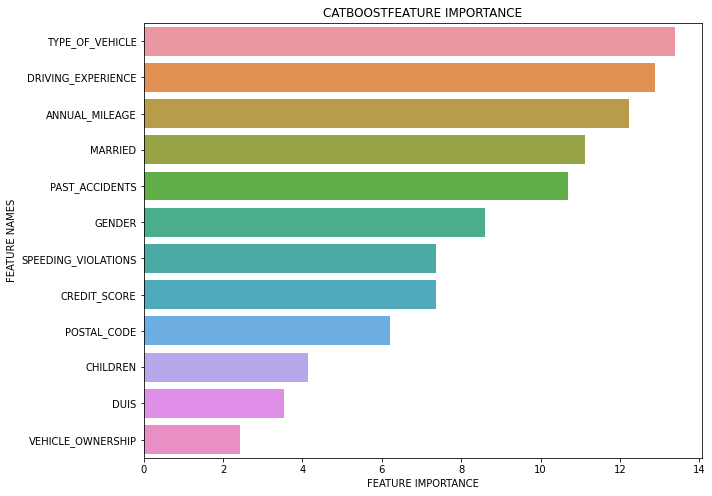

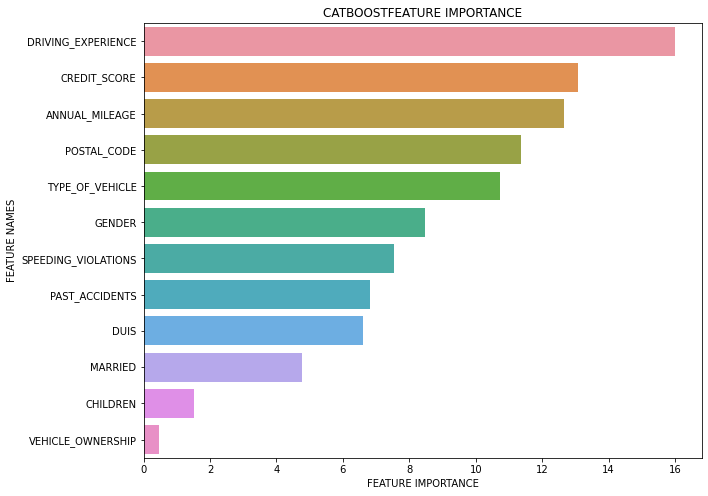

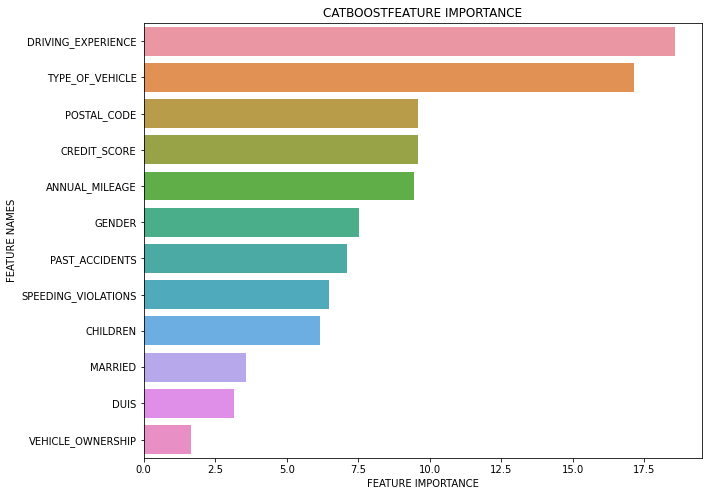

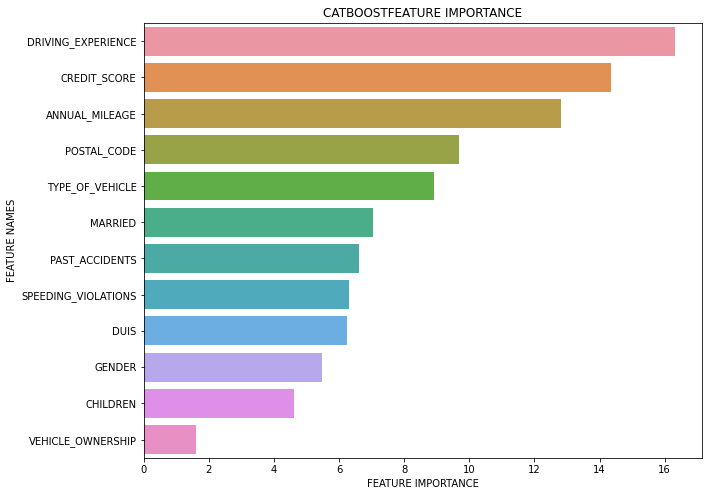

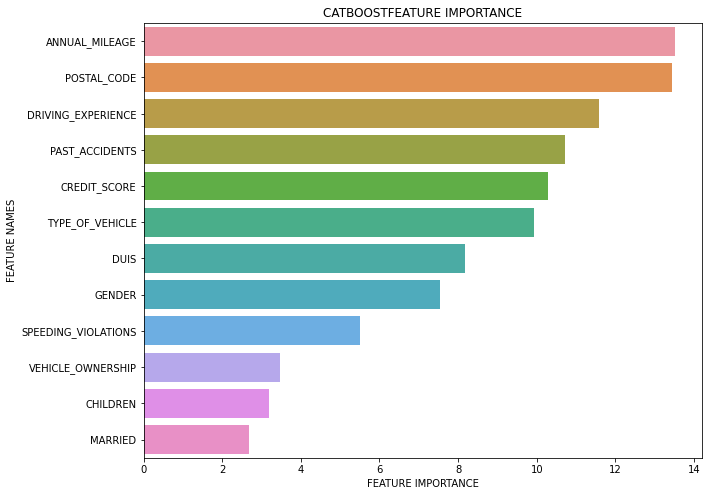

In [32]:
oof, test_pred = train_with_cat(train, test, _eval=False)

In [33]:
submission =  pd.DataFrame({'OUTCOME': test_pred})

In [34]:
submission['OUTCOME'].to_csv('submission_v20.csv', index=False)

<AxesSubplot:xlabel='OUTCOME', ylabel='Count'>

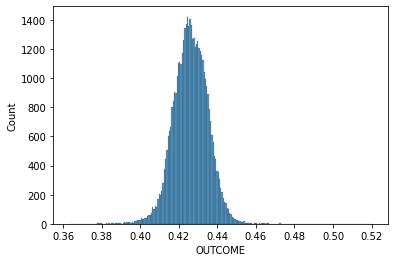

In [19]:
sns.histplot(submission['OUTCOME'])